# ニューラルネットワークの学習

In [1]:
import sys, os
sys.path.append('deep-learning-from-scratch')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline


## 損失関数

ニューラルネットワークの性能の悪さを示す基準。  
認識の精度自体はパラメータの微調整によってあまり変わらないが、損失関数はパラメータの影響を細かく受ける。  (傾きが0にならない)  
NNは損失関数を使って訓練していく。

In [2]:
# 答えが2のデータ
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # one-hot表現

# 2 が正解の可能性が高い場合
y1 = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

# 7が正解の可能性が高い場合
y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]


### 二乗和誤差

In [3]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

print("y1: ", mean_squared_error(np.array(y1), np.array(t)))
print("y2: ", mean_squared_error(np.array(y2), np.array(t)))

y1:  0.0975
y2:  0.5975


###  交差エントロピー誤差

`E = - sum(t, log(y))`

In [4]:
def cross_entropy_error(y, t):
    delta = 1e-7 # 0divideしない
    return -np.sum(t * np.log(y + delta))

print("y1: ", cross_entropy_error(np.array(y1), np.array(t)))
print("y2: ", cross_entropy_error(np.array(y2), np.array(t)))

y1:  0.510825457099
y2:  2.30258409299


## ミニバッチ学習

全てのデータに対して毎回損失関数の和を求めるのには時間がかかってしまう。  
そのため、データの一部をサンプリング（=ミニバッチ）してそのミニバッチごと学習を行うことを`ミニバッチ学習`という。

In [5]:
from dataset.mnist import load_mnist

(x_train, y_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [6]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
y_batch = y_train[batch_mask]


In [7]:
## ミニバッチに対応した交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = t.reshape(1, t.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

### 勾配
 勾配の示す方向: 関数の値を最も減らす方向

x=5 0.1999999999990898
x=10 0.2999999999986347


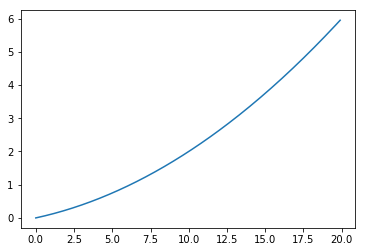

In [8]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

def f1(x):
    """y = 0.01x**2 + 0.1x"""
    return 0.01 * x ** 2 + 0.1 * x

x = np.arange(0, 20, 0.1)
y1 = f1(x)
plt.plot(x, y1, label="f1")

print('x=5', numerical_diff(f1, 5))
print('x=10', numerical_diff(f1, 10))

In [9]:
def f2(x):
    """f(x_0, x_1) = x_0**2 + x_1 ** 2"""
    return np.sum(x ** 2)

In [10]:
#　勾配
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # xと同じ形の配列を作る
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        #  f(x  + h)
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad        

In [11]:
numerical_gradient(f2, np.array([3.0, 4.0]))

array([ 6.,  8.])

## 勾配法
 
 1. 現在の場所から勾配方向へ一定距離進む
 1. 移動した先で購買を求める
 1. 1.に戻る 
 
 関数の極小値や最小値、また鞍点と呼ばれる場所では勾配が0になる。
 また、ほとんど平らな場所に迷い込むと、「プラトー」と呼ばれる学習が進まない停滞期に陥る場合がある。
 

### 学習率
一回学習でどれだけ学習すべきか。  
ハイパーパラメータ(ユーザが指定するパラメータ)

array([ -6.11110793e-10,   8.14814391e-10])

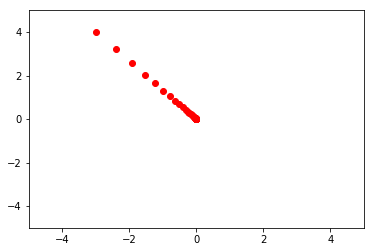

In [12]:
# 勾配法で、f2の最小値を求める

init_x = np.array([-3.0, 4.0])

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    xy = np.array([x])
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr* grad
        xy = np.r_[xy, np.array([x])]
    plt.plot(xy.T[0], xy.T[1], 'ro')
    plt.axis([-5, 5, -5, 5])
    return x

gradient_descent(f2, init_x, lr=0.1, step_num=100)


array([ -2.91829320e-21,  -2.44845461e-22])

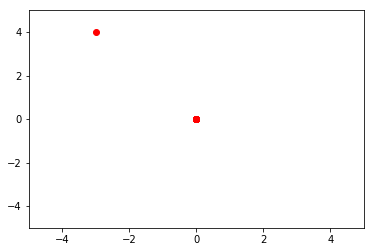

In [13]:
init_x = np.array([-3.0, 4.0])
gradient_descent(f2, init_x, lr=0.5, step_num=100)

array([-0.39785867,  0.53047822])

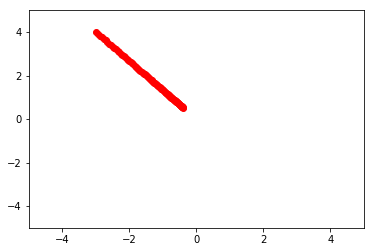

In [14]:
init_x = np.array([-3.0, 4.0])
gradient_descent(f2, init_x, lr=0.01, step_num=100)

## ニューラルネットワークに対する勾配


In [15]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布で初期化
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

In [16]:
net = simpleNet()
print("weight", net.W)

x = np.array([0.6, 0.9])
p = net.predict(x)
print("predicts:", p)

t = np.array([0, 0, 1]) # 正解ラベルを作る
net.loss(x, t)

weight [[ 0.21303232  0.92694627  0.89759441]
 [ 1.18460318  0.92348223 -0.53154004]]
predicts: [ 1.19396225  1.38730177  0.06017061]


2.0640268604181107

In [17]:
def f(W):
    return net.loss(x, t)


# lossの勾配を調べる
dW = numerical_gradient(f, net.W)

dW

array([[ 0.23667655,  0.28715839, -0.52383494],
       [ 0.35501482,  0.43073759, -0.78575241]])

## 学習アルゴリズム

1. ミニバッチ 訓練データからランダムに一部を選び出し、ミニバッチと呼ぶ。
2. ミニバッチの損失関数を減らすために、各重みのパラメータの勾配を調べる。
3. 重みパラメータの勾配方向に微小量更新する
4. 1.へ戻る

確率的勾配降下法(SGDと呼ばれる)

## 二層のニューラルネットワーク

In [18]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        """損失関数の値を求める"""
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        """認識精度を求める"""
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        """重みパラメータに対する勾配を求める"""
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        """numerical_gradientの高速版"""
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [19]:
# hidden_size: 隠れ層のsize。適当。
# 重みパラメータの初期化はとても重要。しかし今回はガウス分布に従う乱数で。

net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

for key, value in net.params.items():
    print(key, value.shape)

W1 (784, 100)
b1 (100,)
W2 (100, 10)
b2 (10,)


In [20]:
# 必要なデータのロード
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list = []

"""
ハイパーパラメータ
"""
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num): # ミニバッチの取得
#     if (i%100) == 0:
#         print ("--", i)
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    #  grad = network.numerical_gradient(x_batch, t_batch) 
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]
            
    # 学習経過の記録
    loss = network.loss(x_batch, t_batch) 
    train_loss_list.append(loss)

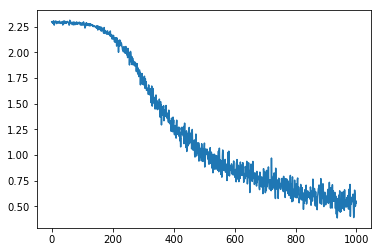

In [21]:
plt.plot(train_loss_list)

## エポック

1エポック:学習において訓練データをすべてえ使い切ったときの回数  
10000のデータを１００を100のミニバッチで学習するのであれば、100回繰り返して１エポック。

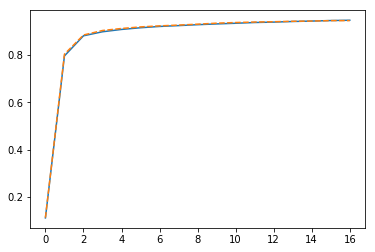

In [23]:
# 必要なデータのロード

"""
ハイパーパラメータ
"""
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1


train_loss_list = []
train_acc_list = []
test_acc_list=[]
# 1エポックあたりの　繰り返しの数
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num): # ミニバッチの取得

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    #  grad = network.numerical_gradient(x_batch, t_batch) 
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]
            
    # 学習経過の記録
    loss = network.loss(x_batch, t_batch) 
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train) # 訓練データ自体の認識精度
        test_acc = network.accuracy(x_test, t_test) # テストデータの認識精度
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

plt.plot(train_acc_list)
plt.plot(test_acc_list, linestyle='--')

1エポックごとに、認識精度を測る。
訓練データでも、テストデータでもきちんと精度が上がっていることがわかった。